# What Creates a Win
In this notebook I will explore what creates a win and how teams can work towards winning more games.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler

In [2]:
def get_season_data():
    """
    This function returns the data for all the seasons with 162 games played 
    and only the columns of interests.
    """
    # import the data
    df = pd.read_csv('data/Teams.csv')
    columns = ['G', 'W', 'R', 'AB', 'H', '2B',
           '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER',
           'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP']
    data = df[columns].copy()
    data = data[data.G == 162]
    
    return data.drop('G', axis=1)

In [3]:
df = get_season_data()

__Column Descriptions__
- `W`: Wins

__Offensive Columns__
- `R`: Runs Scored
- `AB`: At-Bats
- `H`: Hits
- `2B`: Doubles
- `3B`: Triples
- `HR`: Homeruns
- `BB`: Walks
- `SO`: Strikeouts
- `SB`: Stolen Bases
- `CS`: Failed Attempts to steal a base
- `HBP`: Hit By Pitch
- `SF`: Sacrifice Flies

__Defensive Columns__
- `RA`: Runs Allowed
- `ER`: Earned Runs
- `CG`: Complete Games
- `SHO`: Shutouts
- `SV`: Saves
- `IPouts`: Innings Pitched 
- `HA`: Hits Allowed
- `BBA`: Walks Allowed
- `SOA`: Strikeouts Against
- `E`: Errors
- `DP`: Double Plays (when you get two outs in one play. A pitcher's best friend.)

## Linear Regression for Wins

In [4]:
df.isnull().sum()

W           0
R           0
AB          0
H           0
2B          0
3B          0
HR          0
BB          0
SO          0
SB          0
CS          1
HBP       103
SF        104
RA          0
ER          0
CG          0
SHO         0
SV          0
IPouts      0
HA          0
HRA         0
BBA         0
SOA         0
E           0
DP          0
dtype: int64

- There are null values. I will fill them with the mean for those columns.

In [5]:
cs_mean =df['CS'].mean()
hbp_mean =df['HBP'].mean()
sf_mean =df['SF'].mean()

# Replace NaNs
df['CS'].fillna(value=cs_mean, inplace=True)
df['HBP'].fillna(value=hbp_mean, inplace=True)
df['SF'].fillna(value=sf_mean, inplace=True)

In [6]:
def fit_and_plot_linear_model(data, model, scale=True):
    """
    This function takes in the season data and fits specified linear model, plots the coeffs, and returns the fitted model.
    """
    # split the data
    # I am not doing a train test split on purpose. I am more interested in the beta coefficients.
    X = data.iloc[:, 1:].copy()
    target = data.iloc[:, 0].copy()
    cols = X.columns
    
    if scale:
        # normalize X
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
    
    # fit the model
    model.fit(X, target)
    # get the coefficients
    betas = model.coef_
    
    # plot the beta coefs
    plt.subplots(figsize=(12, 8))
    plt.bar(x=cols, height=betas)
    plt.title('Beta Coefficients')
    plt.xlabel('Column')
    plt.ylabel('Beta Value')
    plt.axhline(0, c='r', alpha=0.5, linestyle='--')
    plt.show()
    
    return model

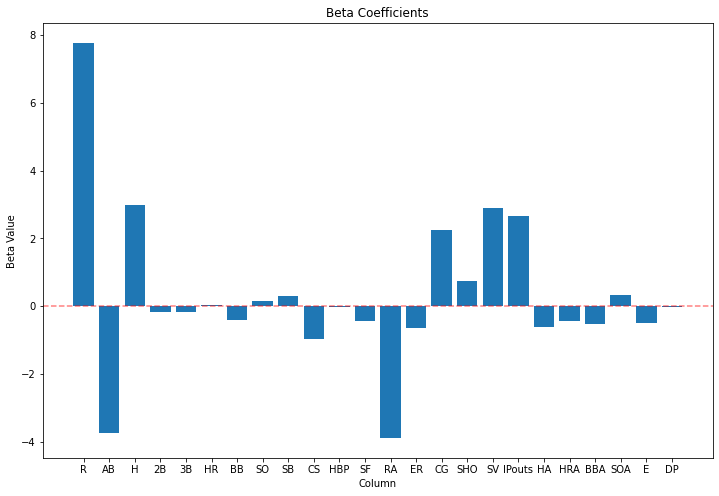

In [7]:
lr_wins = LinearRegression()
lr_wins = fit_and_plot_linear_model(df, lr_wins)

### Rough Interpretation

We can see that Runs Scored, Hits, Complete Games, Shoutouts, Saves, and Innings Pitched have sizable positive beta coefficients. We also can see that Runs Allowed has a negative coefficient. What surprised me is that At-Bats have a negative coefficent. What we may be seeing is that some of these columns directly impact wins, like Complete Games, Shutouts, Saves, Innings Pitched and At-Bats. Every Save leads to a win, because it is when a pitcher throws the last inning of a game that is within 3 runs. Shutouts and Complete Games indicate a great performace for the pitcher, which mostlikely leads to a win. Innings Pitched also causes a win because if the home team wins a game, then they do not come to bat in the bottom of the 9th, so they only bat for 8 innings and pitch for 9 innings. The same is true for At-Bats.
- Lets try Lasso Regression in hopes of eliminating some variables

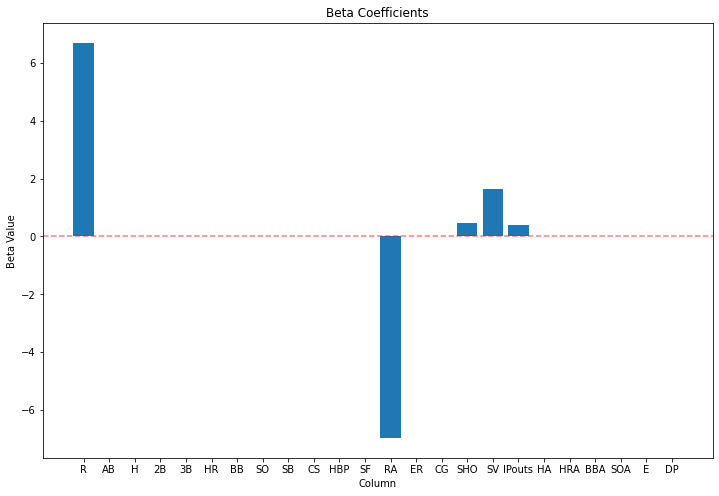

In [8]:
lasso_wins = Lasso()
lasso_wins = fit_and_plot_linear_model(df, lasso_wins)

Nice, we see that Runs Scored and Runs Allowed are the most impactful features, while Shutouts, Saves, and Innings Pitched have importance, this is because they directly lead to wins. Next I regress Wins against Run Differential.

In [9]:
# create the run differential column
df.loc[:, 'run_diff'] = df.R - df.RA

In [10]:
# we have to reshape it to this so we can fit the linear model 
run_diff = np.array(df.run_diff).reshape(-1, 1)

lr = LinearRegression()
lr.fit(run_diff, df.W)
print('beta coef:', round(float(lr.coef_), 3))
print('intercept:', round(lr.intercept_, 3))
print('R-Squared:', round(lr.score(run_diff, df.W), 4))

beta coef: 0.102
intercept: 80.951
R-Squared: 0.8796


- The R-Squared value of 0.879 means that run differential and wins are highly correlated.
- With a coefficient of 0.102, this means a team must score 10 more runs then they allow to expect to win an additional game.
- What is truly remarkable is the intercept term being about 81. This is exactly half of the games in a season!

In [11]:
m, c = np.polyfit(df.run_diff, df.W, 1)

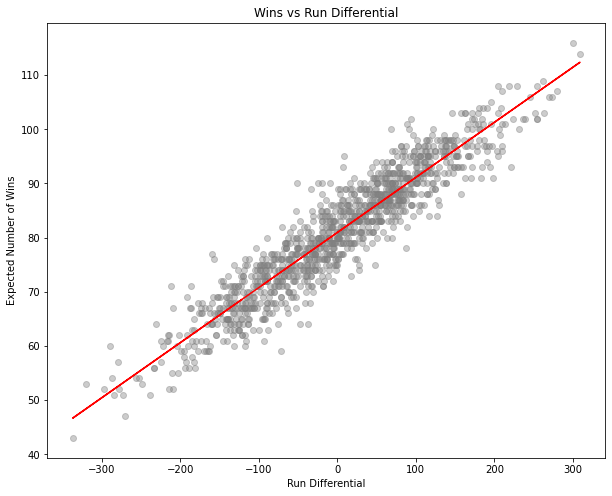

In [12]:
# plot a scatter plot for run differential and wins
plt.subplots(figsize=(10, 8))
plt.scatter(x=df.run_diff, y=df.W, c='grey', alpha=0.4)
plt.plot(df.run_diff, m*df.run_diff+c, c='r')

plt.title('Wins vs Run Differential')
plt.xlabel('Run Differential')
plt.ylabel('Expected Number of Wins')
plt.show()

Wow! Look how linear this relationship is. Now that I have shown that Wins and Run Differential have a strong linear relationship, I will explore what create a positive Run Differential.

## What Creates a positive Run Differential
I will run a regression for runs scored and runs allowed.

In [13]:
df.head()

,W,R,AB,H,2B,3B,HR,BB,SO,SB,...,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,run_diff
438,62,505,5321,1231,154,69,11,344.0,633.0,112.0,...,15,0,4290,1345,16,433,556,273,92,-122
1366,61,683,5423,1342,216,47,90,580.0,772.0,58.0,...,5,23,4245,1519,141,629,703,174,160,-180
1367,70,744,5424,1331,218,22,189,681.0,1068.0,37.0,...,5,34,4314,1391,180,713,973,192,154,-40
1377,77,652,5491,1363,225,34,156,516.0,931.0,45.0,...,8,33,4386,1373,147,549,898,122,152,-28
1379,85,707,5514,1415,250,56,92,620.0,674.0,76.0,...,13,28,4353,1380,123,537,821,110,153,49


## Runs Scored

In [14]:
offensive_columns = ['R', 'AB', 'H', '2B','3B', 'HR', 
                     'BB', 'SO', 'SB', 'CS', 'HBP']
offensive_data = df[offensive_columns].copy()

# create a column for singles
singles = df.H - df['2B'] - df['3B'] - df['HR']
offensive_data.insert(3, '1B', singles)

# drop hits column 
offensive_df = offensive_data.drop('H', axis=1)

In [15]:
offensive_df.head()

,R,AB,1B,2B,3B,HR,BB,SO,SB,CS,HBP
438,505,5321,997,154,69,11,344.0,633.0,112.0,45.556027,34.000000
1366,683,5423,989,216,47,90,580.0,772.0,58.0,22.000000,47.258364
1367,744,5424,902,218,22,189,681.0,1068.0,37.0,28.000000,47.258364
1377,652,5491,948,225,34,156,516.0,931.0,45.0,32.000000,47.258364
1379,707,5514,1017,250,56,92,620.0,674.0,76.0,40.000000,47.258364


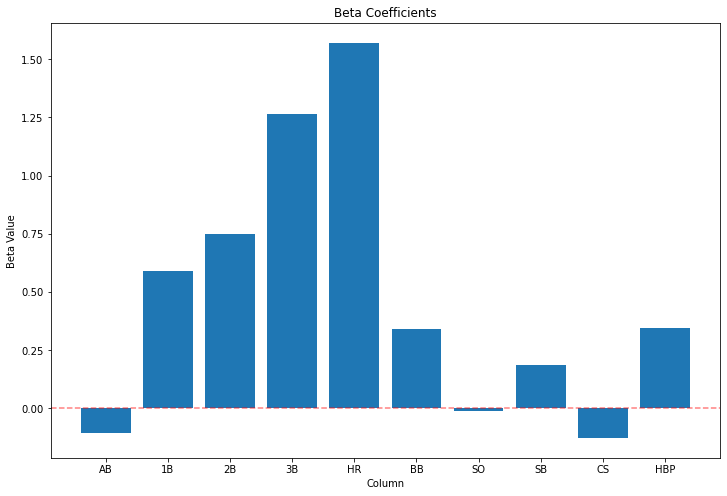

In [16]:
lr_runs = LinearRegression()
lr_runs = fit_and_plot_linear_model(offensive_df, lr_runs, scale=False)

In [17]:
print('Run Value of a Single:', round(lr_runs.coef_[1], 3))
print('Run Value of a Double:', round(lr_runs.coef_[2], 3))
print('Run Value of a Triple:', round(lr_runs.coef_[3], 3))
print('Run Value of a Homerun:', round(lr_runs.coef_[4], 3))
print('Run Value of a Walk:', round(lr_runs.coef_[5], 3))

Run Value of a Single: 0.592
Run Value of a Double: 0.75
Run Value of a Triple: 1.266
Run Value of a Homerun: 1.571
Run Value of a Walk: 0.34


- Lets look at Runs vs Total Bases

In [18]:
total_bases = offensive_df['1B'] + 2*offensive_df['2B'] + 3*offensive_df['3B'] + 4*offensive_df['HR'] + offensive_df['BB'] + offensive_df['HBP']  

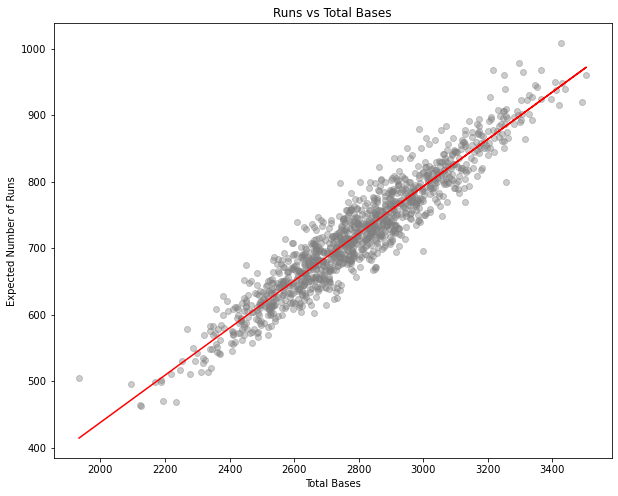

Correlation between Total Bases and Runs 0.9479


In [19]:
lr_bases = LinearRegression()
lr_bases.fit(np.array(total_bases).reshape(-1, 1), offensive_df.R)

m, c = np.polyfit(total_bases, offensive_df.R, 1)

# plot a scatter plot for total bases and runs
plt.subplots(figsize=(10, 8))
plt.scatter(x=total_bases, y=offensive_df.R, c='grey', alpha=0.4)
plt.plot(total_bases, m*total_bases+c, c='r')

plt.title('Runs vs Total Bases')
plt.xlabel('Total Bases')
plt.ylabel('Expected Number of Runs')
plt.show()

print('Correlation between Total Bases and Runs', round(np.corrcoef(total_bases, offensive_df.R)[0][1], 4))

With such a large correlation between Total Bases and Runs scored, teams should be focused on getting on base anyway possible and with homeruns being worth 3 times a single, then that should also be a focus. Disclaimer: this is not the exact way the MLB calcuated expected runs for hit types. Check this article out if you would like more information. [Baseball Linear Weights](https://library.fangraphs.com/principles/linear-weights/)

## Runs Allowed

In [20]:
defensive_columns = ['RA', 'CG', 'SHO', 'SV', 'IPouts', 
                     'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP']
defensive_df = df[defensive_columns].copy()

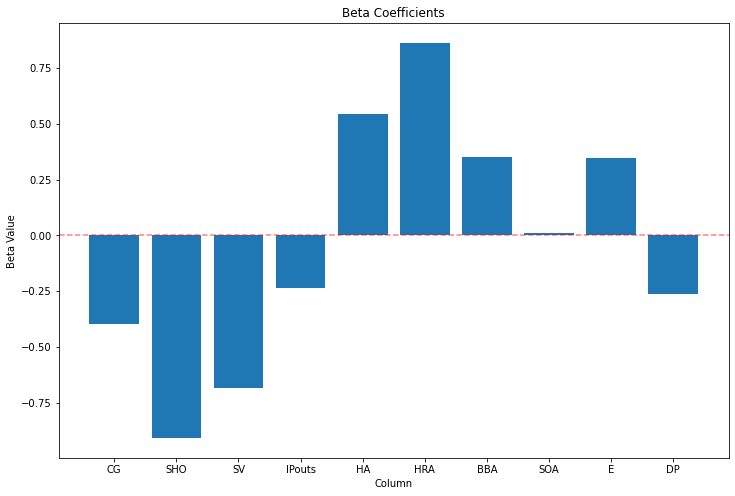

In [21]:
lr_def = LinearRegression()
lr_def = fit_and_plot_linear_model(defensive_df, lr_def, scale=False)

Something similar is seen in the Runs Allowed regression, the more hits a team allows, the more runs they allow. 